In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import gc
import os
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import amp

from torchvision.utils import make_grid


import ddpm

# Configure

In [ ]:
from dataclasses import dataclass


@dataclass
class BaseConfig:  # noqa: D101
    DEVICE = ddpm.get_default_device()
    DATASET = "Cifar-10"  #  "MNIST", "Cifar-10", "Cifar-100", "Flowers"

    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", DATASET, "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", DATASET, "checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"


@dataclass
class TrainingConfig:  # noqa: D101
    TIMESTEPS = 1000  # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32) if BaseConfig.DATASET == "MNIST" else (3, 32, 32)
    NUM_EPOCHS = 30
    BATCH_SIZE = 128
    LR = 2e-4
    NUM_WORKERS = 2


@dataclass
class ModelConfig:  # noqa: D101
    BASE_CH = 64  # 64, 128, 256, 512
    BASE_CH_MULT = (1, 2, 4, 8)  # 32, 16, 8, 4
    APPLY_ATTENTION = (False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 2  # 128

# Load and Visualize Data

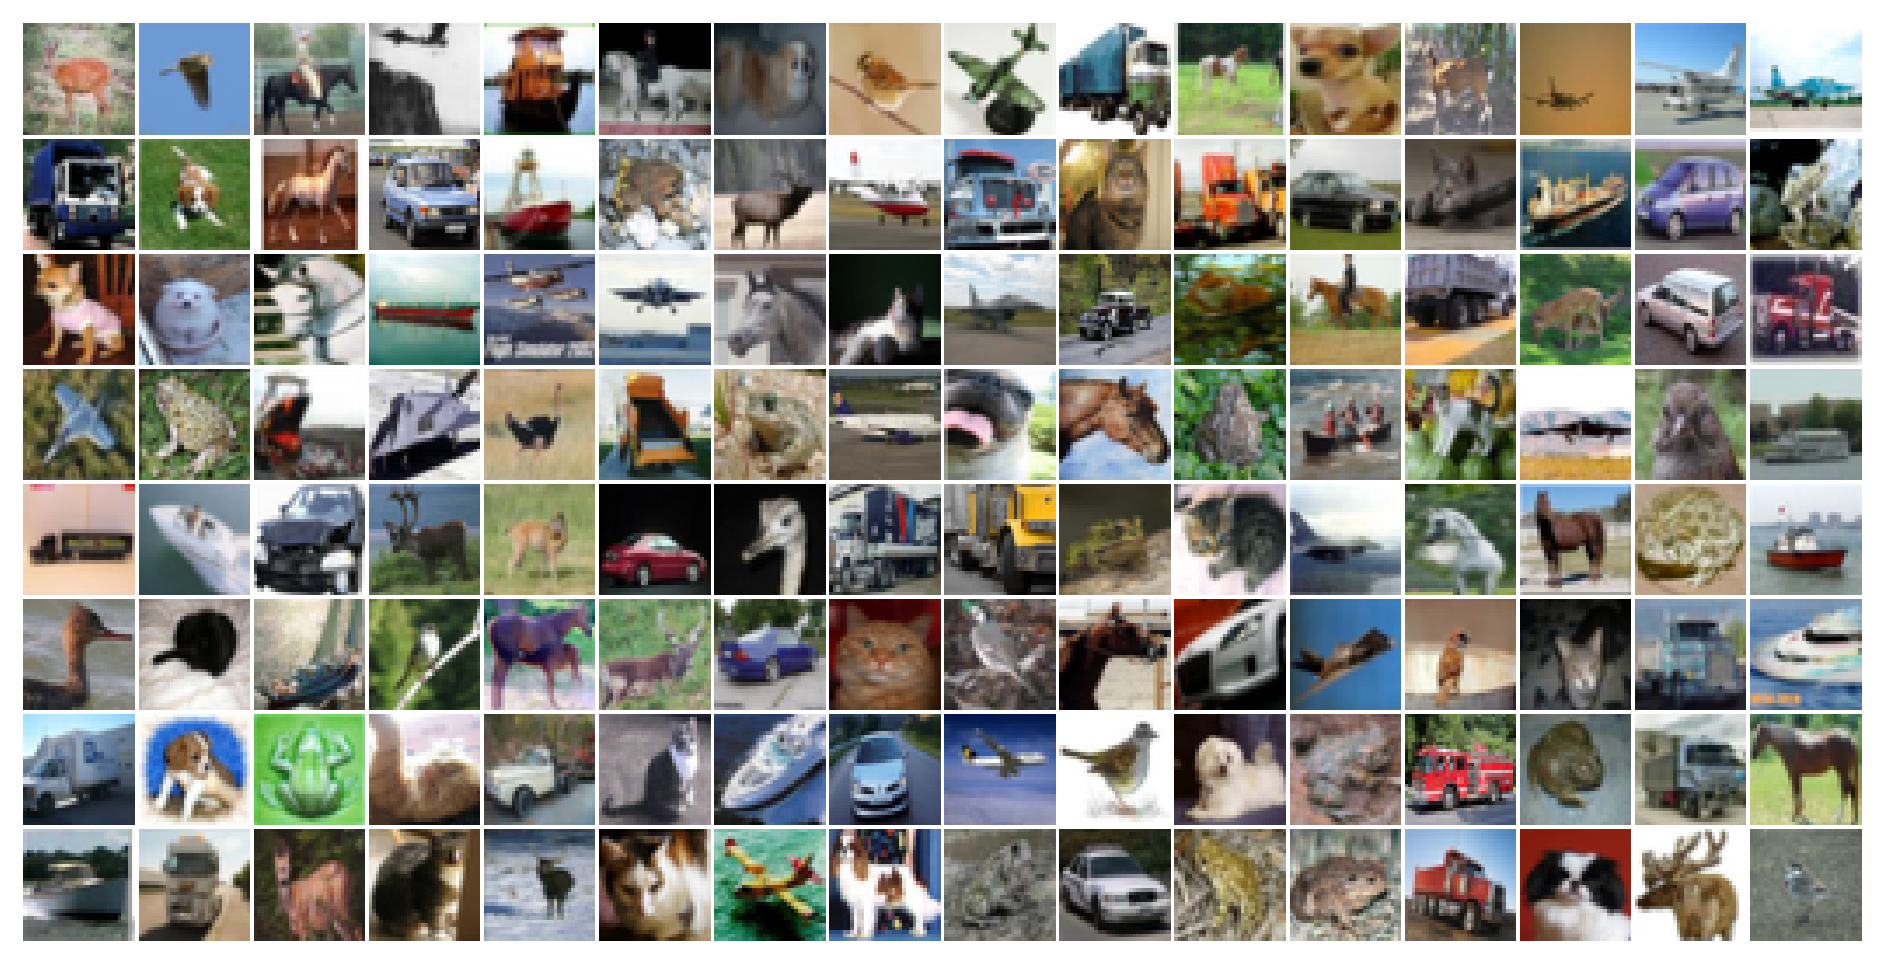

In [10]:
loader = ddpm.get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device="cpu",
)

plt.figure(figsize=(12, 6), facecolor="white", dpi=200)

for b_image, _ in loader:
    b_image = ddpm.inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

# Diffusion Process

## Sample Forward Diffusion Process

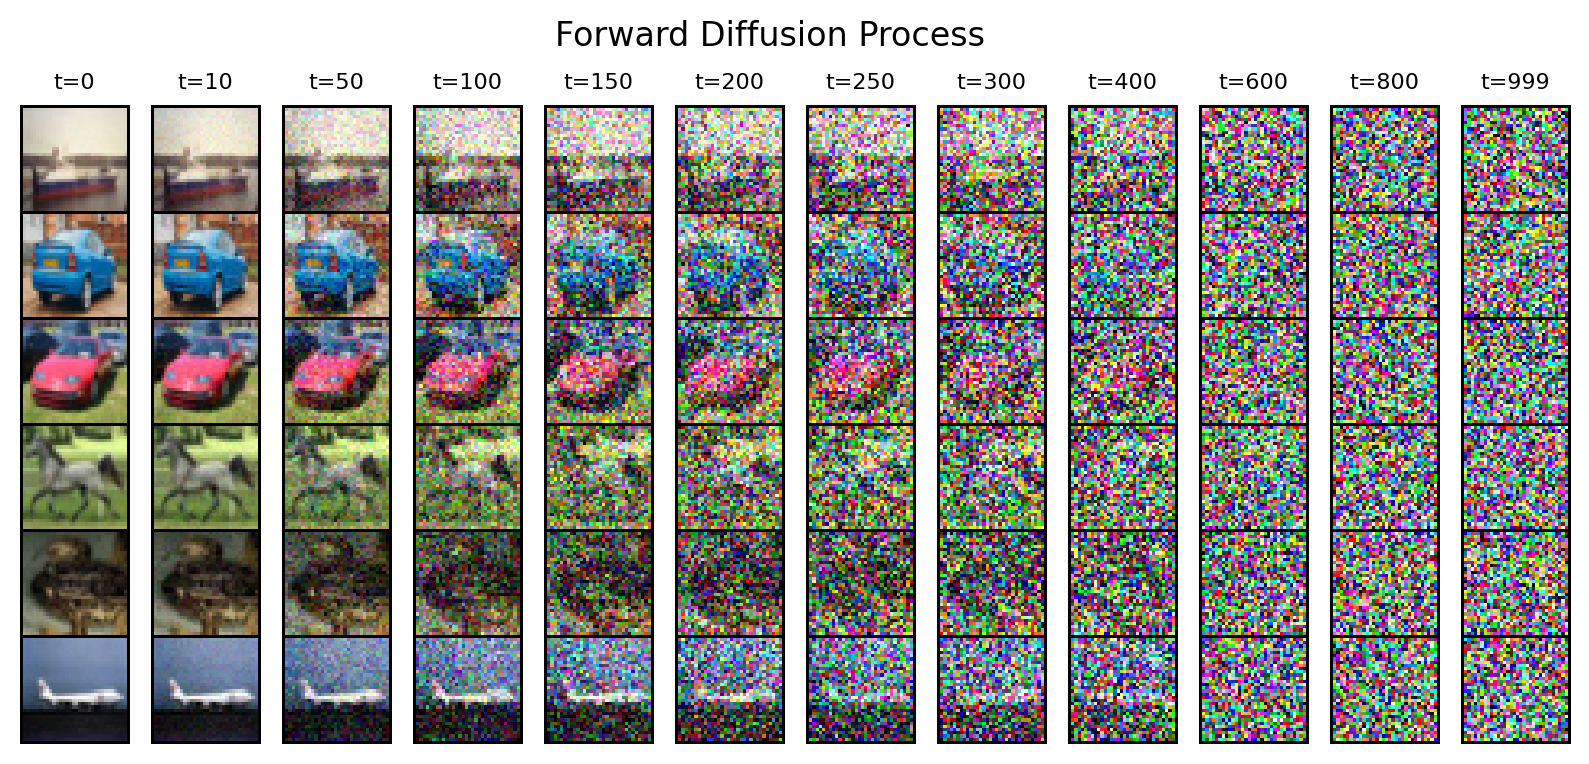

In [11]:
diffusion = ddpm.SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device="cpu")

loader = iter(  # converting dataloader into an iterator for now.
    ddpm.get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device="cpu",
    )
)

x0s, _ = next(loader)

noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = ddpm.forward_diffusion(diffusion, x0s, timestep)
    xts = ddpm.inverse_transform(xts) / 255.0
    xts = make_grid(xts, nrow=1, padding=1)

    noisy_images.append(xts)

# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor="white", dpi=200)

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images, strict=False)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

# Training

In [12]:
model = ddpm.UNet(
    input_channels=TrainingConfig.IMG_SHAPE[0],
    output_channels=TrainingConfig.IMG_SHAPE[0],
    base_channels=ModelConfig.BASE_CH,
    base_channels_multiples=ModelConfig.BASE_CH_MULT,
    apply_attention=ModelConfig.APPLY_ATTENTION,
    dropout_rate=ModelConfig.DROPOUT_RATE,
    time_multiple=ModelConfig.TIME_EMB_MULT,
)
model.to(BaseConfig.DEVICE)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in model: {total_params:,}")

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)

dataloader = ddpm.get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=TrainingConfig.BATCH_SIZE,
    device=BaseConfig.DEVICE,
    pin_memory=True,
    num_workers=TrainingConfig.NUM_WORKERS,
)

loss_fn = nn.MSELoss()

diffusion = ddpm.SimpleDiffusion(
    num_diffusion_timesteps=TrainingConfig.TIMESTEPS,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
)

scaler = amp.GradScaler(BaseConfig.DEVICE)

total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = ddpm.setup_log_directory(config=BaseConfig())

generate_video = False
ext = ".mp4" if generate_video else ".png"

Total parameters in model: 57,153,923
Logging at: Logs_Checkpoints/Cifar-10/Inference/version_0
Model Checkpoint at: Logs_Checkpoints/Cifar-10/checkpoints/version_0


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

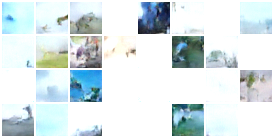

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

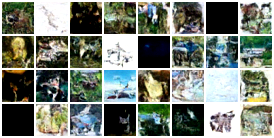

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

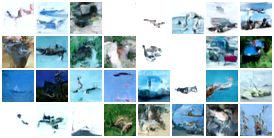

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

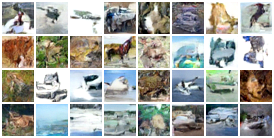

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

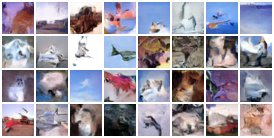

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

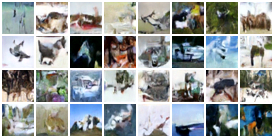

In [13]:
for epoch in range(1, total_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    # Algorithm 1: Training
    ddpm.train_one_epoch(model, diffusion, dataloader, optimizer, scaler, loss_fn, epoch=epoch)

    # Sample images every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch} completed. Sampling images...")
        save_path = os.path.join(log_dir, f"{epoch}{ext}")

        ddpm.reverse_diffusion(
            model,
            diffusion,
            timesteps=TrainingConfig.TIMESTEPS,
            num_images=32,
            generate_video=generate_video,
            save_path=save_path,
            img_shape=TrainingConfig.IMG_SHAPE,
            device=BaseConfig.DEVICE,
        )

        # clear_output()
        checkpoint_dict = {"opt": optimizer.state_dict(), "scaler": scaler.state_dict(), "model": model.state_dict()}
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar"))
        del checkpoint_dict

# Inference

In [ ]:
model = ddpm.UNet(
    input_channels=TrainingConfig.IMG_SHAPE[0],
    output_channels=TrainingConfig.IMG_SHAPE[0],
    base_channels=ModelConfig.BASE_CH,
    base_channels_multiples=ModelConfig.BASE_CH_MULT,
    apply_attention=ModelConfig.APPLY_ATTENTION,
    dropout_rate=ModelConfig.DROPOUT_RATE,
    time_multiple=ModelConfig.TIME_EMB_MULT,
)

if os.path.isdir(BaseConfig.root_log_dir):
    folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(BaseConfig.root_log_dir)]
    last_version_number = max(folder_numbers)
checkpoint_dir = f"Logs_Checkpoints/{BaseConfig.DATASET}/checkpoints/version_{last_version_number}/"

model.load_state_dict(torch.load(f"{checkpoint_dir}/ckpt.tar", map_location="cpu")["model"])
model.to(BaseConfig.DEVICE)

diffuion = ddpm.SimpleDiffusion(
    num_diffusion_timesteps=TrainingConfig.TIMESTEPS,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

inference_results/MNIST-20250625-161933.mp4


Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

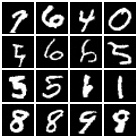

In [17]:
generate_video = True
ext = ".mp4" if generate_video else ".png"
filename = f"{BaseConfig.DATASET}-{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"
save_path = os.path.join(log_dir, filename)
print(save_path)
ddpm.reverse_diffusion(
    model,
    diffusion,
    num_images=16,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=4,
)